<a href="https://colab.research.google.com/github/xusky69/dissipative-dynamics/blob/main/qutip_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qutip

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from qutip import *

sns.set_theme()

# QuTIP dissipative quantum dynamics


In [3]:
def quantumDissipativeCircuit(H_S, H_SB, circuit, rho, observables, plot = True):
    '''
    Recibe:
        H_S: hamiltoniano del sistema
        H_SB: hamiltoniano de acople baño-sistema, lista de 1 elemento
        circuit: lista de tuplas (Gate, Time) que definen las compuertas y su respectivo tiempo de aplicación
        rho: matriz densidad inicial del sistema
        observables: lista de tuplas (observables, etiquetas), observables a medir y sus respectivas etiquetas
        plot: graficar o no
    Retorna:
        rho: matriz densidad final del sistema
        t : lista de tiempos
        results: valor esperado de los observables para t
    '''

    applyGate = lambda rho, gate : gate*rho*gate.dag()
    circuit.sort(key = lambda arr : arr[1])
    obs = list(map(lambda arr : arr[0], observables))
    labels = list(map(lambda arr : arr[1], observables))
    prev_time = 0
    t_list = []
    results = []
    final_results = []

    for gate,time in circuit:
        t = np.linspace(prev_time, time, 100)
        t_list.append(t)
        states = mesolve(H_S, rho, t, H_SB, []).states
        results.append(mesolve(H_S, rho, t, H_SB, obs).expect)
        rho = applyGate(states[-1], gate)
        prev_time = time

    if plot:
        fig = plt.figure(dpi = 80)
        for i in range(len(obs)):
            final_result = np.concatenate(list(map(lambda arr : arr[i], results)))
            final_results.append(final_result)
            plt.plot(np.concatenate(t_list), final_result)
        plt.legend(labels)
        plt.title('Dissipative quantum circuit' if len(H_SB) != 0 else 'Ideal quantum circuit' )
        plt.show(fig)

    return [rho, np.concatenate(t_list), final_results]

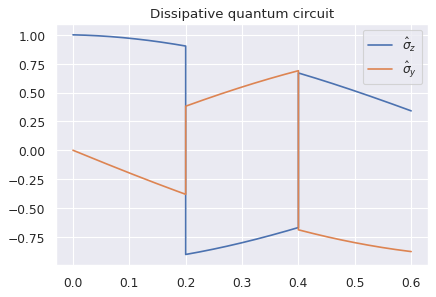

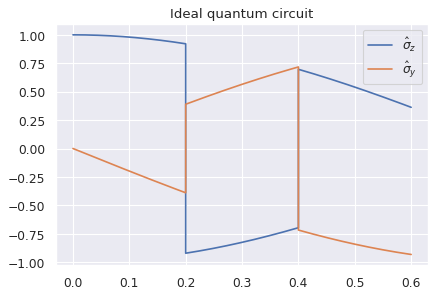

Fidelity between real and dissipative circuits final density matrices is 0.9853337790652422


In [9]:
H_S = sigmax()
H_SB = np.sqrt(0.05)*sigmax()
circuit = [(sigmax(),0.2),(sigmax(),0.4), (qeye(2),0.6)]
observables = [(sigmaz(), '$\hat{\sigma}_z$'), (sigmay(), '$\hat{\sigma}_y$')]
rho = basis(2, 0)
rho = rho*rho.dag()

d_rho, _, _  = quantumDissipativeCircuit(H_S = H_S, H_SB = [H_SB], circuit = circuit, rho = rho, observables = observables)
e_rho, _, _  = quantumDissipativeCircuit(H_S = H_S, H_SB = []    , circuit = circuit, rho = rho, observables = observables)
print('Fidelity between real and dissipative circuits final density matrices is {}'.format(fidelity(d_rho, e_rho)))